# Lab 03 : LeNet5 architecture - solution

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils
import time

### With or without GPU?

It is recommended to run this code on GPU:<br> 
* Time for 1 epoch on CPU : 96 sec (1.62 min)<br> 
* Time for 1 epoch on GPU : 2 sec w/ GeForce GTX 1080 Ti <br>

In [2]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


### Download the MNIST dataset 

In [3]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
test_data=torch.load(data_path+'mnist/test_data.pt')
test_label=torch.load(data_path+'mnist/test_label.pt')

print(train_data.size())
print(test_data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


### Compute average pixel intensity over all training set and all channels

In [4]:
mean= train_data.mean()

print(mean)

tensor(0.1307)


### Compute standard deviation

In [5]:
std= train_data.std()

print(std)

tensor(0.3081)


### Make a LeNet5 convnet class. 

In [6]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   28 x 28  -->    50 x 28 x 28 
        self.conv1 = nn.Conv2d(1,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 28 x 28 -->    50 x 14 x 14
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   50 x 14 x 14  -->    100 x 14 x 14 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 14 x 14 -->    100 x 7 x 7
        self.pool2 = nn.MaxPool2d(2,2)
        
        # LL1:   100 x 7 x 7 = 4900 -->  100 
        self.linear1 = nn.Linear(4900, 100)
        
        # LL2:   100  -->  10 
        self.linear2 = nn.Linear(100,10)


    def forward(self, x):

        # CL1:   28 x 28  -->    50 x 28 x 28 
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 50 x 28 x 28 -->    50 x 14 x 14
        x = self.pool1(x)
        
        # CL2:   50 x 14 x 14  -->    100 x 14 x 14
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 100 x 14 x 14 -->    100 x 7 x 7
        x = self.pool2(x)

        # LL1:   100 x 7 x 7 = 4900  -->  100 
        x = x.view(-1, 4900)
        x = self.linear1(x)
        x = F.relu(x)
        
        # LL2:   4900  -->  10 
        x = self.linear2(x)
    
        return x

### Build the net. How many parameters in total?

In [25]:
net=LeNet5_convnet()
print(net)
utils.display_num_param(net)

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4900, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)
There are 536710 (0.54 million) parameters in this neural network


### Send the weights of the networks to the GPU (as well as the mean and std)

In [26]:
net = net.to(device)

mean=mean.to(device)

std=std.to(device)

### Choose the criterion, learning rate, and batch size.

In [27]:
criterion = nn.CrossEntropyLoss()

my_lr=0.25 

bs= 128

### Function to evaluate the network on the test set

In [28]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs].unsqueeze(dim=1)
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std    # ONLY CHANGE IS HERE!

        scores=net( inputs ) 

        error = utils.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

### Do 30 passes through the training set. Divide the learning rate by 2 every 5 epochs.

In [29]:
start=time.time()

for epoch in range(1,30):
    
    if not epoch%5:
        my_lr = my_lr / 1.5
        
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(60000)
 
    for count in range(0,60000,bs):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices].unsqueeze(dim=1)
        minibatch_label=  train_label[indices]
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std      # ONLY CHANGE IS HERE!
        
        inputs.requires_grad_()

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label) 
          
        loss.backward()
        
        optimizer.step()
        

        # COMPUTE STATS
        
        running_loss += loss.detach().item()
        
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')
    
    

epoch= 1 	 time= 0.035965096950531 min 	 lr= 0.25 	 loss= 0.25184304937561436 	 error= 8.281138939643974 percent
error rate on test set = 1.720727848101266 percent
 
epoch= 2 	 time= 0.07331464687983195 min 	 lr= 0.25 	 loss= 0.04753592156215326 	 error= 1.5175239872068231 percent
error rate on test set = 1.2163765822784811 percent
 
epoch= 3 	 time= 0.11227930784225464 min 	 lr= 0.25 	 loss= 0.03212023202353703 	 error= 0.9600435238657221 percent
error rate on test set = 1.2954905063291138 percent
 
epoch= 4 	 time= 0.14929946660995483 min 	 lr= 0.25 	 loss= 0.023746630387392633 	 error= 0.7168398991322467 percent
error rate on test set = 1.0284810126582278 percent
 
epoch= 5 	 time= 0.1872205177942912 min 	 lr= 0.16666666666666666 	 loss= 0.013608026010458912 	 error= 0.40367358783160695 percent
error rate on test set = 0.8801424050632911 percent
 
epoch= 6 	 time= 0.22588123877843222 min 	 lr= 0.16666666666666666 	 loss= 0.010225599255737489 	 error= 0.2765191897654584 percent
error

### Choose image at random from the test set and see how good/bad are the predictions

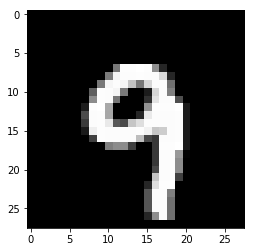

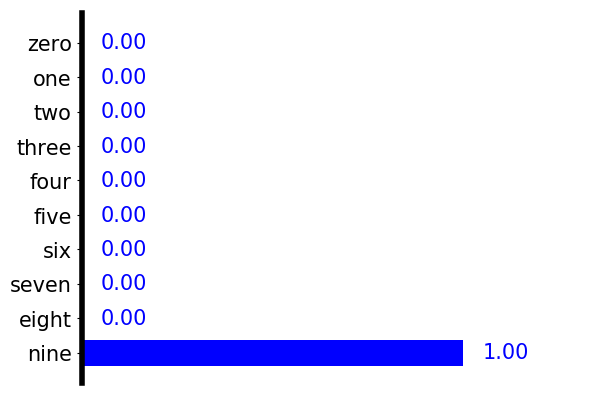

In [12]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
im= (im-mean) / std
im=im.view(1,28,28).unsqueeze(dim=1)

# feed it to the net and display the confidence scores
scores =  net(im) 
probs= F.softmax(scores, dim=1)
utils.show_prob_mnist(probs.cpu())